In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from natsort import natsorted
from sklearn.mixture import GaussianMixture

from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
from statsmodels.tsa.stattools import acf
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
from skimage.feature import SIFT, match_descriptors,plot_matches
from skimage.feature import ORB

import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from itertools import permutations 
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread

In [2]:
def load_data(path_num,path_all = False):
    # if (path_num==0) or (path_num=='before'):
    #     path = 'rgb/before/'
    # elif (path_num==1) or (path_num=='after'):
    #     path = 'rgb/after/'
    # elif (path_num==2) or (path_num=='after_2min'):
    if path_all:
        path = path_all
    else:
        path = f'volume_data/Hadiya_10_15_2024_Timelapse/registered/{path_num}/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)

    temp_img = cv2.imread(path+pic_paths[0],cv2.IMREAD_UNCHANGED) 
    imgs_from_folder = np.zeros((len(pic_paths),temp_img.shape[0],temp_img.shape[1]))
    # imgs_from_folder = []
    for i,j in enumerate(pic_paths):
        aa = cv2.imread(path+j,cv2.IMREAD_UNCHANGED)
        imgs_from_folder[i] = aa.copy()
    imgs_from_folder = imgs_from_folder.astype(np.float32)
    return imgs_from_folder

In [452]:
# os.mkdir('11_13_2024/registered')

In [627]:
pics_without_line = np.array(tiffread('12_4_2024/Medain_hadiya_8.tif')).astype(np.float32)

In [628]:
# n = pics_without_line.shape[1]
n = 1400
nn = []
for i in range(pics_without_line.shape[0]):
    nn.append(np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)))

UP, DOWN = np.min(nn)-30,np.max(nn)+30
UP, DOWN

(389, 482)

In [629]:
# pics_without_line = pics_without_line[np.r_[0:250,260:500]]

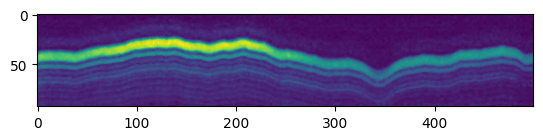

In [630]:
mid = 1240
plt.imshow(pics_without_line.transpose(2,1,0)[200][UP:DOWN])

In [631]:
tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

warping: 100%|██████████| 500/500 [00:08<00:00, 61.32it/s]


In [632]:
# UP,DOWN = 1050,1170


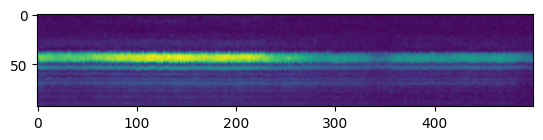

In [633]:
plt.imshow(pics_without_line.transpose(2,1,0)[200][UP:DOWN])

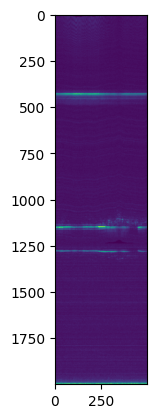

In [634]:
plt.imshow(pics_without_line.transpose(2,1,0)[100])

# Y-Motion

In [635]:
def min_max(data1):
    if np.all(data1 == data1[0]):
        return data1
    else:
        data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
        return data1

def div3(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = phase(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = phase_join_chunks(data[:i],data[i:i+3])
    return data

def phase(data,dis=False):
    n = data.shape[0]//2
    for i in range(data.shape[0]):
        coords = phase_cross_correlation(data[n][UP:DOWN][:,300:]
                                        ,data[i][UP:DOWN][:,300:]
                                        ,normalization=None,upsample_factor=20)[0]
        data[i] = scp.shift(data[i],shift = (coords[0],0),mode='constant',order=3)
    return data

def phase_join_chunks(first,second):
    coords = phase_cross_correlation(first[-1][UP:DOWN][:,300:]
                                    ,second[0][UP:DOWN][:,300:]
                                    ,normalization=None,upsample_factor=20)[0]
    for i in range(len(second)):
        second[i] = scp.shift(second[i],shift = (coords[0],0),mode='constant',order=3)
    return second


def div3_reg_optz(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = man_reg(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = man_join_chunks(data[:i],data[i:i+3])
    return data    

def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(x, tform,order=3)
    return -nmi(y,warped)
    # return mse(y,warped)

def upsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_expand(temp_data,upscale=n,mode='constant', cval=0,order=3)
    return temp_data

def downsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_reduce(temp_data,downscale=n,mode='constant', cval=0,order=3)
    return temp_data


def man_reg(data):
    n = data.shape[0]//2
    # get_masks = cell_extract(data[1],4)
    for i in range(data.shape[0]):
        tform2 = AffineTransform(translation=(0,0))
        if i!=n:
            temp_i_data = data[i].copy()
            # best_mask = compare_masks_phase(get_masks,data[n],temp_i_data)
            for pyr in [4]*5:
                move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (samp((temp_i_data[270:350]),pyr)
                                ,samp((data[n][270:350]),pyr)))['x'])/pyr
                temp_transform = AffineTransform(translation=(move[0],0))
                temp_i_data = warp(temp_i_data, temp_transform,order=3)
                tform2 = np.dot(tform2,temp_transform)
                # print('iter',pyr,mse(data[i], warp(data[i], tform2,order=3)))
            tform2 = AffineTransform(matrix = tform2)
            data[i] = warp(data[i], tform2,order=3)
            # print('done')
    return data



In [636]:
# pics_without_line[:,:1240] = div3(pics_without_line[:,:1240])

In [637]:
# def ants_reg_mapping(stat,mov):
#     ants1 = ants.from_numpy(stat.astype(np.float32))
#     ants2 = ants.from_numpy(mov.astype(np.float32))
#     # mov_mask = ants.from_numpy(moving_mask.astype(np.float64))
#     reg = ants_register(ants1,ants2,type_of_transform = 'Translation',aff_iterations=(1100, 1200, 1000, 1000))
#     # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
#     return reg['fwdtransforms']


# def mse_fun_tran(shif,x,y):
#     tform = AffineTransform(translation=(0,shif[0]))
#     warped = warp(x, tform,order=3)
#     return -nmi(y,warped)

In [638]:
# # n = pics_without_line.shape[1]
# n = 1400
# nn = []
# for i in range(pics_without_line.shape[0]):
#     nn.append(np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)))

# UP, DOWN = np.min(nn)-30,np.max(nn)+30

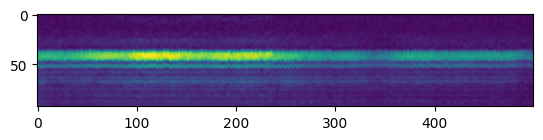

In [639]:
plt.imshow(pics_without_line.transpose(2,1,0)[100][UP:DOWN])

In [640]:
# def ants_all_trans(pics_without_line):
#     transforms_all = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
#     for i in tqdm(range(pics_without_line.shape[0]-1),desc='tr_all'):
#         # tff = AffineTransform(translation=(0,0))
#         mat = scipy.io.loadmat(ants_reg_mapping(min_max(pics_without_line[i][UP:DOWN][:,300:]),min_max(pics_without_line[i+1][UP:DOWN][:,300:]))[0])
#         # tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
#         tff = AffineTransform(matrix = np.vstack((mat['AffineTransform_float_2_2'].reshape(2,3,order='F'),[0,0,1])))
#         transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
#     return transforms_all

In [641]:
# mat = scipy.io.loadmat(ants_reg_mapping(min_max(pics_without_line[70][UP:DOWN]),min_max(pics_without_line[71][UP:DOWN]))[0])
# AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))

In [642]:
# np.vstack((mat['AffineTransform_float_2_2'].reshape(2,3,order='F'),[0,0,1]))

In [643]:
# tr_all = ants_all_trans(pics_without_line)
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:1240]  = warp(pics_without_line[i][:1240],AffineTransform(matrix=tr_all[i]),order=3)

In [644]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(y, tform,order=3)
    return -ncc(x,warped)



def ncc(a,b):
    # print(np.linalg.norm(a),np.linalg.norm(b))
    a = a / np.linalg.norm(a) if np.linalg.norm(a)!=0 else a / 10
    b = b / np.linalg.norm(b) if np.linalg.norm(b)!=0 else b / 10
    # print(np.correlate(a.flatten(), b.flatten(), mode = 'full'))
    return np.correlate(a.flatten(), b.flatten())
    
def ants_all_trans(data):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # tff = AffineTransform(translation=(0,0))
        # PHASE
        coords = phase_cross_correlation(min_max(data[i][UP:DOWN][:,:100])
                                        ,min_max(temp_img[:,:100])
                                        ,normalization=None,upsample_factor=20)[0]
        # temp_img = scp.shift(temp_img,shift = (coords[0],0),mode='constant',order=3)
        if np.abs(coords[0])<=5:
            temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # MANUAL
        temp_tform_manual = AffineTransform(translation=(0,0))
        temp_manual = temp_img.copy()
        for _ in range(5):
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (data[i][UP:DOWN][:,:100]
                                ,temp_manual[:,:100]))['x']
            temp_transform = AffineTransform(translation=(0,move[0]))
            temp_manual = warp(temp_manual, temp_transform,order=3)
            temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
        temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
        if np.abs(np.array(temp_tform_manual)[1,2])<=1:
            temp_img = warp(temp_img,temp_tform_manual,order=3)
            # tff = temp_tform_manual
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)

        # # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:50]),min_max(temp_img[:,:50]))[0])
        # # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=2:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     # ar = np.vstack((mat['AffineTransform_float_2_2'].reshape(2,3,order='F'),[0,0,1]))
        #     # ar[0,2],ar[1,2] = ar[1,2],ar[0,2]
        #     # tff = AffineTransform(matrix = ar)
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all

tr_all = ants_all_trans(pics_without_line)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:08<00:00, 59.81it/s]


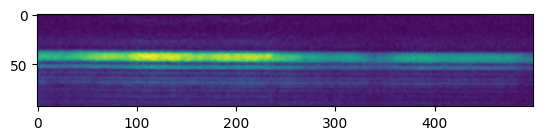

In [645]:
plt.imshow(pics_without_line.transpose(2,1,0)[100][UP:DOWN])

# X-Motion

In [646]:
gg = pics_without_line.copy()

In [647]:
test = pics_without_line.transpose(2,1,0)[100].copy()

In [648]:
bright_point = np.argmax(np.sum(test[:700],axis=1))
dense_point = np.argmax(np.max(test[bright_point+30:bright_point+330],axis=1))+bright_point+30
bot_mirror = dense_point-bright_point-30
shp = test.shape[0]-30-bot_mirror

# transforms_all = np.tile(np.eye(3),(gg.shape[0],1,1))

# for i in tqdm(range(gg.shape[0]-1)):
#     mat = scipy.io.loadmat(ants_reg_mapping(gg[i][1000:1100],
#                                             gg[i+1][1000:1100])[0])
#     # tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))
#     tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

#     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

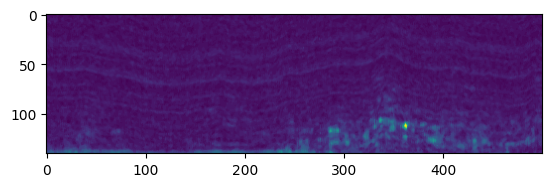

In [649]:
plt.imshow(test[1000:1140])

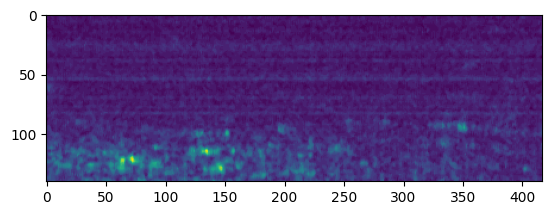

In [650]:
plt.imshow(gg[400][1000:1140])

In [651]:
transforms_all = np.tile(np.eye(3),(gg.shape[0],1,1))

for i in tqdm(range(gg.shape[0]-1)):
    mat = scipy.io.loadmat(ants_reg_mapping(gg[i][1000:1100],
                                            gg[i+1][1000:1100])[0])
    # tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))
    tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

    transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

100%|██████████| 499/499 [02:14<00:00,  3.70it/s]


In [652]:
for i in tqdm(range(gg.shape[0])):
    gg[i] = warp(gg[i],AffineTransform(matrix=transforms_all[i]),order=3)

100%|██████████| 500/500 [00:15<00:00, 32.80it/s]


In [653]:
# np.unique(min_max(gg[367]))

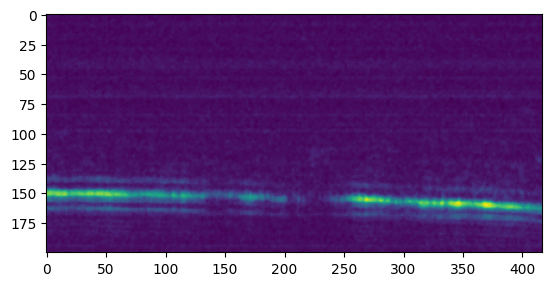

In [654]:
plt.imshow((min_max(gg[147][1000:1200])*255).astype(np.uint8))

In [655]:
# os.mkdir('12_4_2024/test')
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite('12_4_2024/test/'+f'frame_test{i}.PNG',(min_max(j)*255).astype(np.uint8))

500it [00:04, 102.45it/s]


In [656]:
# os.mkdir('12_4_2024/registered')
# os.mkdir('12_4_2024/registered/scan10')

for i,j in tqdm(enumerate(gg)):
    cv2.imwrite('12_4_2024/registered/scan8/'+f'frame_test{i}.PNG',(min_max(j)*65535).astype(np.uint16))

500it [00:08, 57.69it/s]
